In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Setup and Imports
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Bidirectional, GRU
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

print("✓ All imports successful")

✓ All imports successful


In [18]:
def load_and_filter_fold(i):
    train_dir = f'/content/drive/MyDrive/split_data/fold{i}/train.csv'
    test_dir = f'/content/drive/MyDrive/split_data/fold{i}/test.csv'
    train_df = pd.read_csv(train_dir)
    test_df = pd.read_csv(test_dir)

    train_labels = list(train_df['room'].unique())
    test_labels = list(test_df['room'].unique())
    common_labels = list(set(train_labels) & set(test_labels))

    train_df = train_df[train_df['room'].isin(common_labels)].reset_index(drop=True)
    test_df = test_df[test_df['room'].isin(common_labels)].reset_index(drop=True)

    return train_df, test_df

# Load all 4 folds
train_df_1, test_df_1 = load_and_filter_fold(1)
train_df_2, test_df_2 = load_and_filter_fold(2)
train_df_3, test_df_3 = load_and_filter_fold(3)
train_df_4, test_df_4 = load_and_filter_fold(4)

print("✓ All folds loaded")

✓ All folds loaded


In [19]:
def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

def create_room_groups(df):
    df = df.sort_values('timestamp').reset_index(drop=True)
    df['room_group'] = (df['room'] != df['room'].shift()).cumsum()
    return df

def create_beacon_count_vectors(df):
    vectors = []
    for _, group in df.groupby('timestamp'):
        beacon_counts = group['mac address'].value_counts()
        total_readings = len(group)

        vector = [0.0] * 23
        for beacon_id, count in beacon_counts.items():
            if 1 <= beacon_id <= 23:
                vector[beacon_id - 1] = count / total_readings

        vectors.append({
            'timestamp': group['timestamp'].iloc[0],
            'room': group['room'].iloc[0],
            'room_group': group['room_group'].iloc[0],
            'beacon_vector': vector
        })

    return pd.DataFrame(vectors)

def create_sequences_from_groups(vector_df, min_length=3, max_length=50):
    sequences = []
    labels = []

    for (room, room_group), group in vector_df.groupby(['room', 'room_group']):
        group = group.sort_values('timestamp').reset_index(drop=False)
        seq_length = len(group)

        if seq_length < min_length:
            continue

        if seq_length > max_length:
            group = group.tail(max_length)
            seq_length = max_length

        sequence = [row['beacon_vector'] for _, row in group.iterrows()]
        sequences.append(sequence)
        labels.append(room)

    return sequences, labels

def build_bidirectional_gru_model(input_shape, num_classes):
    """
    Bidirectional GRU Architecture:
    - Similar to Bidirectional LSTM but faster
    - Fewer parameters, less prone to overfitting
    - Often works as well or better than LSTM
    """
    model = Sequential([
        Masking(mask_value=0.0, input_shape=input_shape),

        Bidirectional(GRU(128, return_sequences=True)),
        Dropout(0.3),

        Bidirectional(GRU(64, return_sequences=False)),
        Dropout(0.3),

        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

print("✅ Helper functions defined (with Bidirectional GRU)")

✅ Helper functions defined (with Bidirectional GRU)


In [20]:
def run_pipeline_single_seed(train_df, test_df, seed, verbose=False):
    """Run pipeline for a single seed"""
    set_seeds(seed)

    # Preprocessing
    train_df = create_room_groups(train_df)
    test_df = create_room_groups(test_df)

    train_vectors = create_beacon_count_vectors(train_df)
    test_vectors = create_beacon_count_vectors(test_df)

    # Sequence creation
    X_train, y_train = create_sequences_from_groups(train_vectors)
    X_test, y_test = create_sequences_from_groups(test_vectors)

    # Encode labels
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train + y_test)
    y_train_encoded = label_encoder.transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Pad sequences
    max_seq_length = 50
    X_train_padded = pad_sequences(X_train, maxlen=max_seq_length, dtype='float32', padding='post', value=0.0)
    X_test_padded = pad_sequences(X_test, maxlen=max_seq_length, dtype='float32', padding='post', value=0.0)

    # Calculate class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_encoded),
        y=y_train_encoded
    )
    class_weight_dict = dict(enumerate(class_weights))

    # Build and train model
    model = build_bidirectional_gru_model(
        input_shape=(max_seq_length, 23),
        num_classes=len(label_encoder.classes_)
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)
    ]

    history = model.fit(
        X_train_padded, y_train_encoded,
        validation_data=(X_test_padded, y_test_encoded),
        epochs=100,
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=0
    )

    # Predictions (sequence level only - no frame propagation)
    y_pred_probs = model.predict(X_test_padded, verbose=0)
    y_pred_encoded = np.argmax(y_pred_probs, axis=1)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)

    # Calculate macro F1
    macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    # Calculate per-class F1
    per_class_f1 = f1_score(y_test, y_pred, average=None, labels=label_encoder.classes_, zero_division=0)
    per_class_f1_dict = {label: f1 for label, f1 in zip(label_encoder.classes_, per_class_f1)}

    return {
        'seed': seed,
        'macro_f1': macro_f1,
        'per_class_f1': per_class_f1_dict,
        'y_true': y_test,           # Added for confusion matrix
        'y_pred': y_pred,           # Added for confusion matrix
        'label_classes': label_encoder.classes_  # Added for confusion matrix
    }

print("✅ Updated pipeline function defined (with confusion matrix support)")

✅ Updated pipeline function defined (with confusion matrix support)


In [21]:
# Run 10 seeds for each of 4 folds
seeds = [42, 123, 456, 789, 2024, 3141, 5926, 8888, 1337, 9999]
folds = {
    1: (train_df_1, test_df_1),
    2: (train_df_2, test_df_2),
    3: (train_df_3, test_df_3),
    4: (train_df_4, test_df_4)
}

all_fold_results = {}

for fold_num, (train_df, test_df) in folds.items():
    print(f"\n{'='*80}")
    print(f"PROCESSING FOLD {fold_num}")
    print(f"{'='*80}\n")

    fold_results = []

    for seed in seeds:
        print(f"  Running seed {seed}...", end=" ")
        result = run_pipeline_single_seed(train_df, test_df, seed, verbose=False)
        fold_results.append(result)
        print(f"Macro F1: {result['macro_f1']:.4f}")

    all_fold_results[fold_num] = fold_results

    # Calculate fold statistics
    macro_f1_scores = [r['macro_f1'] for r in fold_results]
    print(f"\n  Fold {fold_num} Summary:")
    print(f"    Mean Macro F1: {np.mean(macro_f1_scores):.4f} ± {np.std(macro_f1_scores):.4f}")
    print(f"    Min: {np.min(macro_f1_scores):.4f}, Max: {np.max(macro_f1_scores):.4f}")

print("\n" + "="*80)
print("ALL FOLDS COMPLETED!")
print("="*80)


PROCESSING FOLD 1

  Running seed 42... Macro F1: 0.4664
  Running seed 123... Macro F1: 0.5288
  Running seed 456... 

Macro F1: 0.5974
  Running seed 789... Macro F1: 0.5467
  Running seed 2024... Macro F1: 0.6245
  Running seed 3141... Macro F1: 0.5469
  Running seed 5926... Macro F1: 0.5225
  Running seed 8888... Macro F1: 0.6055
  Running seed 1337... Macro F1: 0.5615
  Running seed 9999... Macro F1: 0.5371

  Fold 1 Summary:
    Mean Macro F1: 0.5537 ± 0.0439
    Min: 0.4664, Max: 0.6245

PROCESSING FOLD 2

  Running seed 42... Macro F1: 0.4871
  Running seed 123... Macro F1: 0.5972
  Running seed 456... Macro F1: 0.5615
  Running seed 789... Macro F1: 0.6017
  Running seed 2024... Macro F1: 0.4910
  Running seed 3141... Macro F1: 0.6117
  Running seed 5926... Macro F1: 0.4654
  Running seed 8888... Macro F1: 0.4752
  Running seed 1337... Macro F1: 0.4795
  Running seed 9999... Macro F1: 0.4742

  Fold 2 Summary:
    Mean Macro F1: 0.5245 ± 0.0576
    Min: 0.4654, Max: 0.6117

PROCESSING FOLD 3

  Running seed 42... Macro F1: 0.5939
  Running seed 123... Macro F1: 0.5931
  Running seed 456... Macr

In [22]:
# Save results to text file
with open('4fold_10seed_results.txt', 'w') as f:
    f.write("="*80 + "\n")
    f.write("4-FOLD CROSS-VALIDATION WITH 10 SEEDS PER FOLD\n")
    f.write("="*80 + "\n\n")

    # Overall summary
    all_macro_f1 = []
    for fold_num in [1, 2, 3, 4]:
        fold_scores = [r['macro_f1'] for r in all_fold_results[fold_num]]
        all_macro_f1.extend(fold_scores)

    f.write("OVERALL RESULTS (40 runs total):\n")
    f.write("-"*80 + "\n")
    f.write(f"Mean Macro F1: {np.mean(all_macro_f1):.4f} ± {np.std(all_macro_f1):.4f}\n")
    f.write(f"Min: {np.min(all_macro_f1):.4f}, Max: {np.max(all_macro_f1):.4f}\n\n")

    # Per-fold results
    for fold_num in [1, 2, 3, 4]:
        f.write(f"\n{'='*80}\n")
        f.write(f"FOLD {fold_num} RESULTS\n")
        f.write(f"{'='*80}\n\n")

        fold_results = all_fold_results[fold_num]
        macro_f1_scores = [r['macro_f1'] for r in fold_results]

        f.write(f"Macro F1 Scores (10 seeds):\n")
        f.write("-"*80 + "\n")
        for i, result in enumerate(fold_results):
            f.write(f"  Seed {result['seed']:5d}: {result['macro_f1']:.4f}\n")

        f.write(f"\nStatistics:\n")
        f.write(f"  Mean: {np.mean(macro_f1_scores):.4f} ± {np.std(macro_f1_scores):.4f}\n")
        f.write(f"  Min:  {np.min(macro_f1_scores):.4f}\n")
        f.write(f"  Max:  {np.max(macro_f1_scores):.4f}\n")

        # Per-class F1 (averaged across 10 seeds)
        f.write(f"\nPer-Class F1 Scores (averaged across 10 seeds):\n")
        f.write("-"*80 + "\n")

        # Collect all class names
        all_classes = set()
        for result in fold_results:
            all_classes.update(result['per_class_f1'].keys())

        # Average per-class F1 across seeds
        for class_name in sorted(all_classes):
            class_f1_scores = [r['per_class_f1'].get(class_name, 0) for r in fold_results]
            mean_f1 = np.mean(class_f1_scores)
            std_f1 = np.std(class_f1_scores)
            f.write(f"  {class_name:20s}: {mean_f1:.4f} ± {std_f1:.4f}\n")

print("✅ Results saved to 4fold_10seed_results.txt")

✅ Results saved to 4fold_10seed_results.txt


In [23]:
# Display summary
print("\n" + "="*80)
print("SUMMARY - 4 FOLDS × 10 SEEDS = 40 TOTAL RUNS")
print("="*80 + "\n")

for fold_num in [1, 2, 3, 4]:
    macro_f1_scores = [r['macro_f1'] for r in all_fold_results[fold_num]]
    print(f"Fold {fold_num}: {np.mean(macro_f1_scores):.4f} ± {np.std(macro_f1_scores):.4f}")

all_macro_f1 = []
for fold_num in [1, 2, 3, 4]:
    all_macro_f1.extend([r['macro_f1'] for r in all_fold_results[fold_num]])

print(f"\n{'='*80}")
print(f"Overall Mean: {np.mean(all_macro_f1):.4f} ± {np.std(all_macro_f1):.4f}")
print(f"{'='*80}")


SUMMARY - 4 FOLDS × 10 SEEDS = 40 TOTAL RUNS

Fold 1: 0.5537 ± 0.0439
Fold 2: 0.5245 ± 0.0576
Fold 3: 0.5550 ± 0.0447
Fold 4: 0.4758 ± 0.0983

Overall Mean: 0.5272 ± 0.0725



Processing Fold 1 confusion matrix...
  ✓ Fold 1 confusion matrix generated

Processing Fold 2 confusion matrix...
  ✓ Fold 2 confusion matrix generated

Processing Fold 3 confusion matrix...
  ✓ Fold 3 confusion matrix generated

Processing Fold 4 confusion matrix...
  ✓ Fold 4 confusion matrix generated

✅ Confusion matrices saved to 'confusion_matrices_all_folds.png'


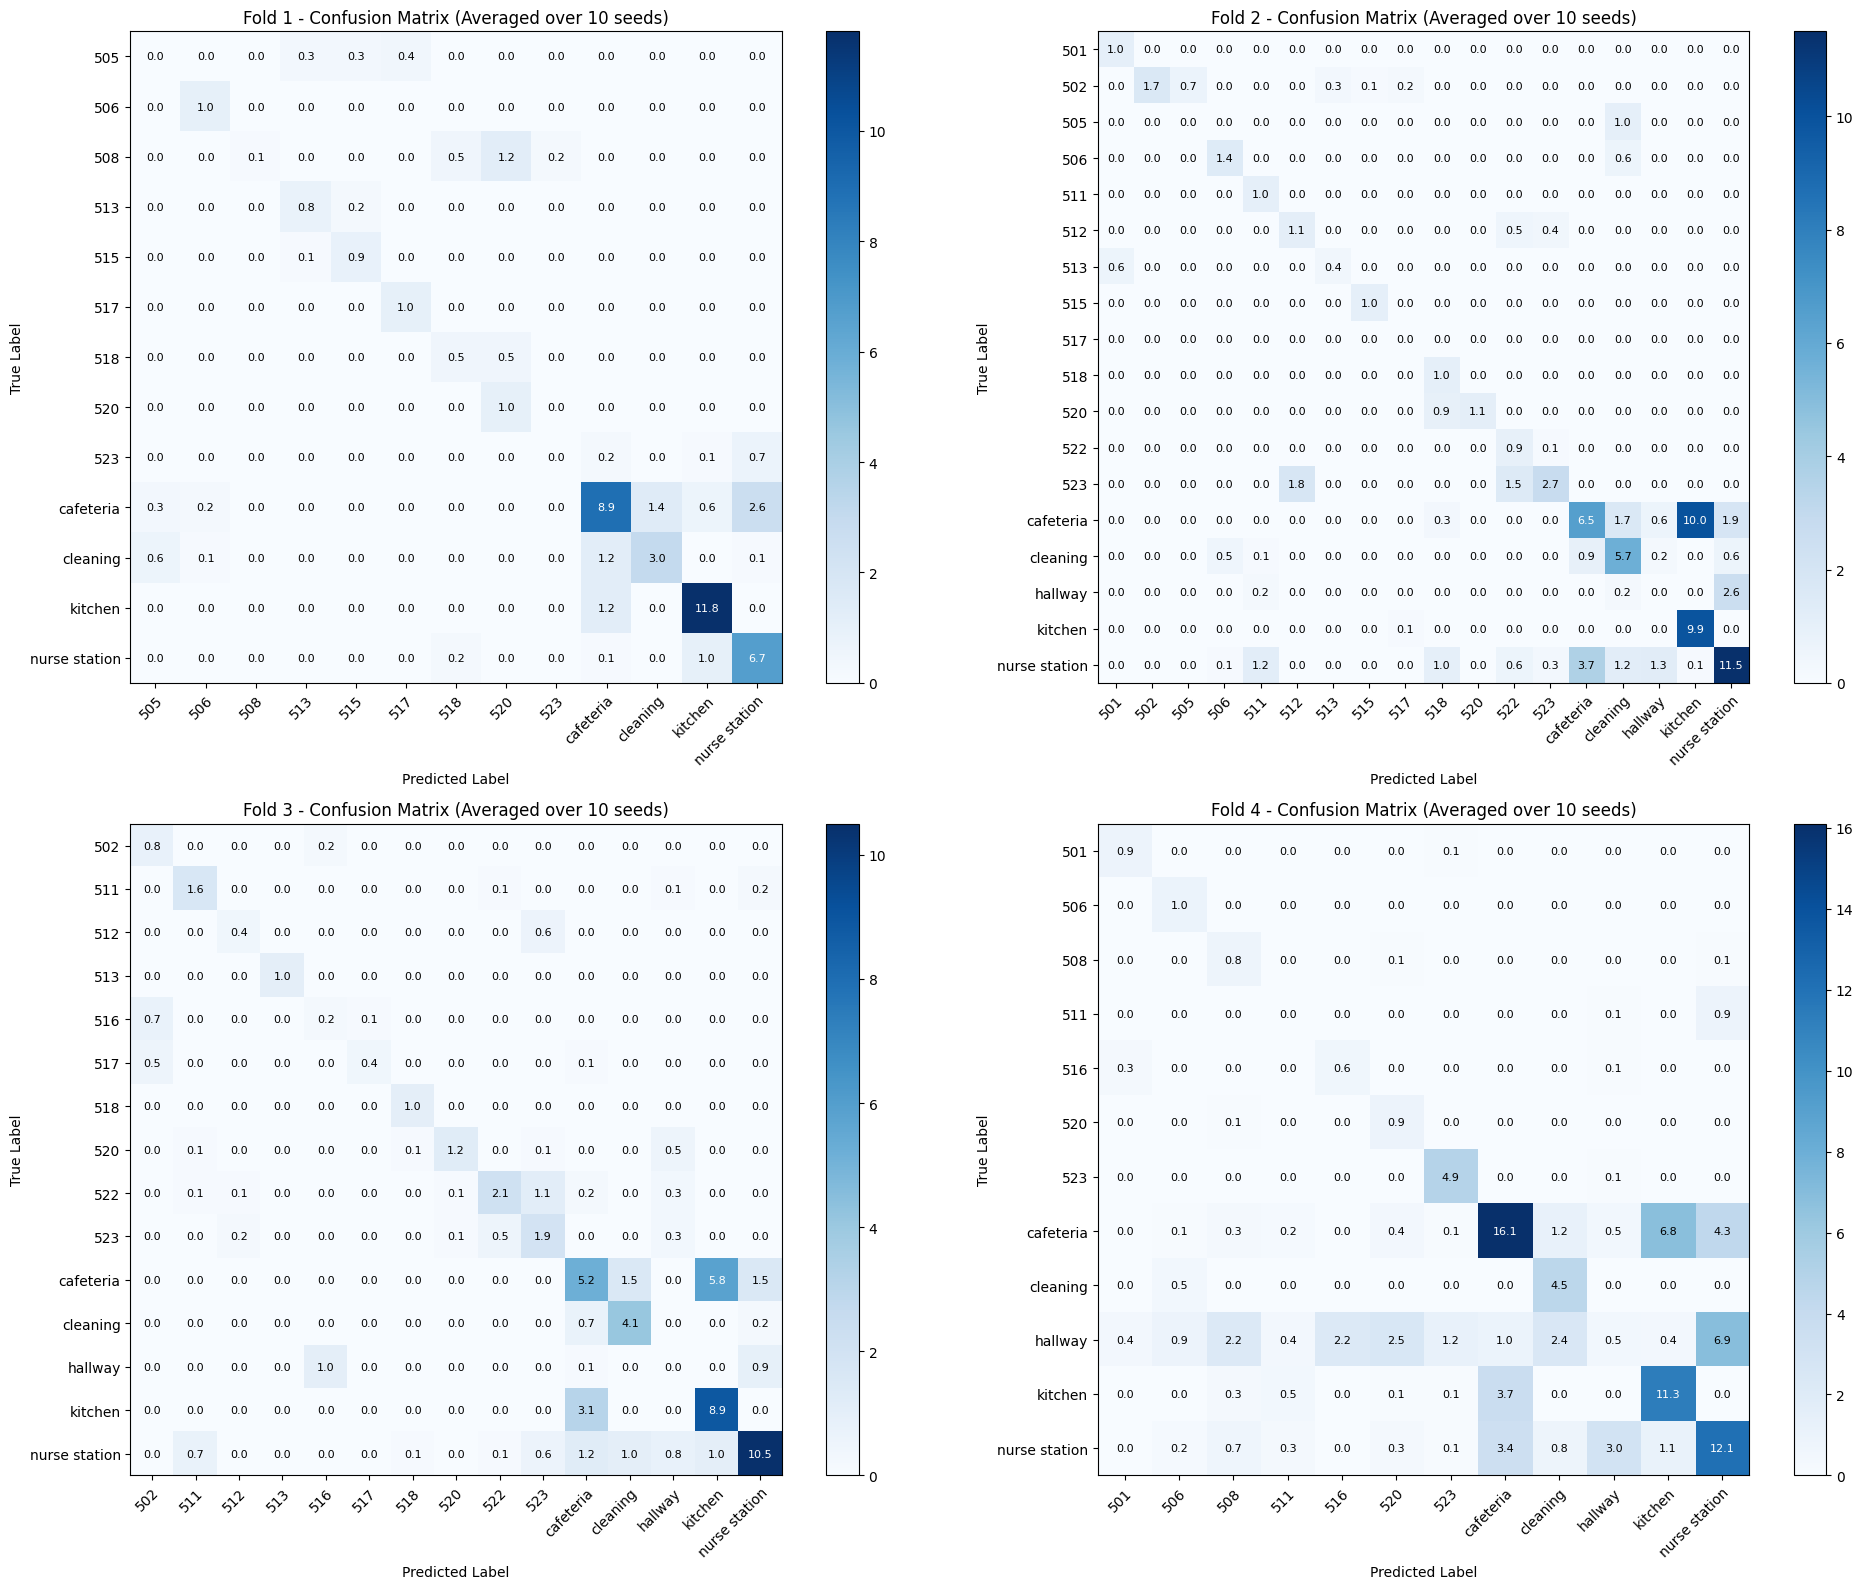


CONFUSION MATRIX STATISTICS

Fold 1:
  Number of classes: 13
  Classes: 505, 506, 508, 513, 515, 517, 518, 520, 523, cafeteria, cleaning, kitchen, nurse station
  Overall Accuracy: 0.7140
  Average predictions per class: 3.8

Fold 2:
  Number of classes: 18
  Classes: 501, 502, 505, 506, 511, 512, 513, 515, 517, 518, 520, 522, 523, cafeteria, cleaning, hallway, kitchen, nurse station
  Overall Accuracy: 0.5518
  Average predictions per class: 4.7

Fold 3:
  Number of classes: 15
  Classes: 502, 511, 512, 513, 516, 517, 518, 520, 522, 523, cafeteria, cleaning, hallway, kitchen, nurse station
  Overall Accuracy: 0.5955
  Average predictions per class: 4.4

Fold 4:
  Number of classes: 12
  Classes: 501, 506, 508, 511, 516, 520, 523, cafeteria, cleaning, hallway, kitchen, nurse station
  Overall Accuracy: 0.5105
  Average predictions per class: 8.8



In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set up the plot style
plt.style.use('default')
sns.set_palette("husl")

# Create figure with 2x2 subplots for 4 folds
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for fold_num in [1, 2, 3, 4]:
    print(f"\nProcessing Fold {fold_num} confusion matrix...")

    fold_results = all_fold_results[fold_num]

    # Get all unique classes across all seeds
    all_classes = set()
    for result in fold_results:
        all_classes.update(result['label_classes'])
    all_classes = sorted(list(all_classes))

    # Initialize accumulated confusion matrix
    n_classes = len(all_classes)
    accumulated_cm = np.zeros((n_classes, n_classes))

    # Accumulate confusion matrices from all 10 seeds
    for result in fold_results:
        y_true = result['y_true']
        y_pred = result['y_pred']

        # Generate confusion matrix for this seed
        cm = confusion_matrix(y_true, y_pred, labels=all_classes)
        accumulated_cm += cm

    # Average across 10 seeds
    avg_cm = accumulated_cm / len(fold_results)

    # Plot confusion matrix
    ax = axes[fold_num - 1]

    # Use a color map
    im = ax.imshow(avg_cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)

    # Set ticks and labels
    ax.set(xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=all_classes,
           yticklabels=all_classes,
           title=f'Fold {fold_num} - Confusion Matrix (Averaged over 10 seeds)',
           ylabel='True Label',
           xlabel='Predicted Label')

    # Rotate the tick labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add text annotations showing the values
    thresh = avg_cm.max() / 2.
    for i in range(n_classes):
        for j in range(n_classes):
            ax.text(j, i, f'{avg_cm[i, j]:.1f}',
                   ha="center", va="center",
                   color="white" if avg_cm[i, j] > thresh else "black",
                   fontsize=8)

    print(f"  ✓ Fold {fold_num} confusion matrix generated")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('confusion_matrices_all_folds.png', dpi=300, bbox_inches='tight')
print("\n✅ Confusion matrices saved to 'confusion_matrices_all_folds.png'")
plt.show()

# Print summary statistics for each fold
print("\n" + "="*80)
print("CONFUSION MATRIX STATISTICS")
print("="*80)

for fold_num in [1, 2, 3, 4]:
    fold_results = all_fold_results[fold_num]

    # Get all unique classes
    all_classes = set()
    for result in fold_results:
        all_classes.update(result['label_classes'])
    all_classes = sorted(list(all_classes))

    # Calculate average confusion matrix
    n_classes = len(all_classes)
    accumulated_cm = np.zeros((n_classes, n_classes))

    for result in fold_results:
        cm = confusion_matrix(result['y_true'], result['y_pred'], labels=all_classes)
        accumulated_cm += cm

    avg_cm = accumulated_cm / len(fold_results)

    # Calculate per-class accuracy
    print(f"\nFold {fold_num}:")
    print(f"  Number of classes: {n_classes}")
    print(f"  Classes: {', '.join(all_classes)}")

    # Diagonal sum (correct predictions)
    correct_predictions = np.trace(avg_cm)
    total_predictions = np.sum(avg_cm)
    overall_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

    print(f"  Overall Accuracy: {overall_accuracy:.4f}")
    print(f"  Average predictions per class: {total_predictions / n_classes:.1f}")

print("\n" + "="*80)